#  Прогнозирование заказов такси

**Постановка задачи:**  
- На основании исторических данных о заказах такси в аэропортах построить модель для предсказания количества заказов на следующий час.  

**Исходные данные:**  
- Файл "taxi.csv", в котором указана дата, время и количество заказов за определённый период.  

**Требования по качеству моделей:**  
- Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.  

**Область применения:**  
- Оптимизация работы такси в часы пиковой нагрузки. 

## Подготовка

Загрузка библиотек.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor

Дополнительные настройки для визуализации.

In [2]:
plt.rcParams.update({'font.size':14, 
                     'figure.figsize':(8,4)})

Загрузка данных. Сразу спарсим даты и сделаем из них индекс. 

In [3]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные представляют собой временной ряд - число заказов такси по временным отрезкам в 10 минут. 

Проверим на монотонность. 

In [4]:
data.index.is_monotonic

True

Всё хорошо, сортировка индекса не требуется. 

In [5]:
data.isnull().sum()

num_orders    0
dtype: int64

Пропусков нет. 

Так как стоит задача прогнозирования количества заказов на следующий час, то выполним ресемплинг с агрегацией по сумме заказов.   

In [6]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные готовы для анализа. 

## Анализ данных

В нашем распоряжении данные с 1 марта до 31 августа 2018г.  
Взглянем на распределение по заказам такси. 

In [7]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


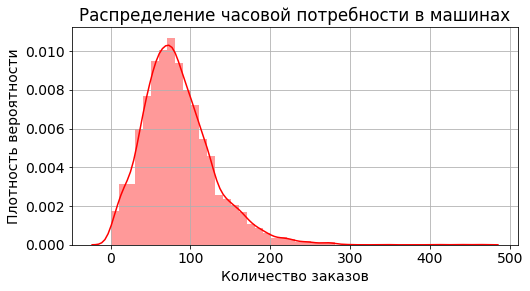

In [8]:
sns.distplot(data, bins=46, color='r')
plt.title('Распределение часовой потребности в машинах')
plt.xlabel('Количество заказов')
plt.ylabel('Плотность вероятности')
plt.grid()
plt.show()

Всего получилось 4416 точек. Минимальное значение - ноль такси в час (ожидаемо), среднее - 84 машины в час, достигнутый рекорд заказов - 462 машины в час. Страшно представить, что там творилось.

Посмотрим на имеющийся временной ряд. 

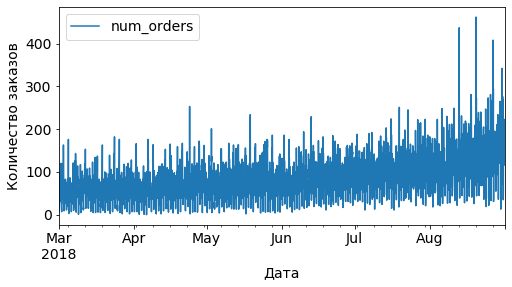

In [9]:
data.plot()
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Какой прекрасный лес! Ничего не понятно. Попробуем сделать его более читабельным. 
Для начала построим скользящее среднее за неделю

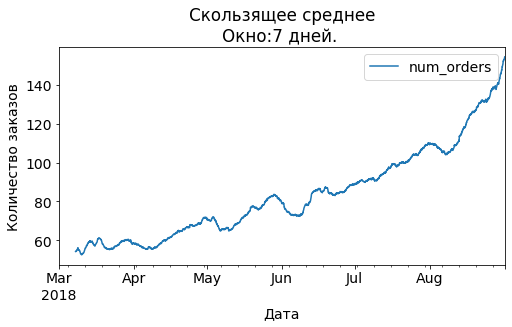

In [10]:
data.rolling(24*7).mean().plot()
plt.title('Скользящее среднее\nОкно:7 дней. ')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Определённо, со временем количество заказов такси в аэропортах растёт. Однако, у нас есть данные только с марта по август, поэтому определить сезонные колебания невозможно. Впрочем, перед нами стоит задача прогнозирования на следующий час.  
Выделим тренд и сезонную составляющую. 

In [11]:
decomposed = seasonal_decompose(data)

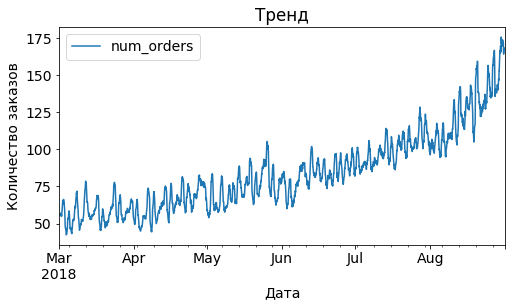

In [12]:
decomposed.trend.plot()
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Тренд фактически повторяет приведённый выше график скользящего среднего. 

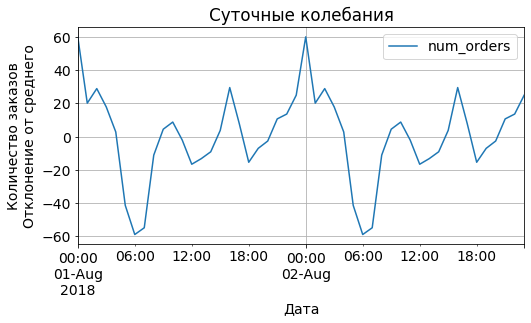

In [13]:
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(grid=True)
plt.title('Суточные колебания')
plt.xlabel('Дата')
plt.ylabel('Количество заказов\nОтклонение от среднего')
plt.show()

В течение суток заказы распределены неравномерно. Пик заказов приходится на полночь. А минимум - на 6 часов утра. Чаще среднего такси заказывают в периоды 8-11, 14-17 и с 19 до 04 часов.  
Посмотрим, как выглядя недельные колебания. 

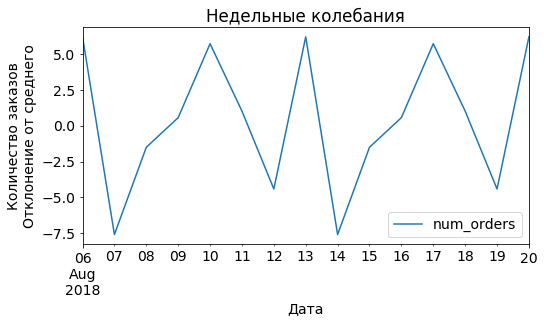

In [14]:
decomposed_days = seasonal_decompose(data.resample('1D').mean())
decomposed_days.seasonal['2018-08-06':'2018-08-20'].plot()
plt.title('Недельные колебания')
plt.xlabel('Дата')
plt.ylabel('Количество заказов\nОтклонение от среднего')
plt.show()

В течение недели наблюдается два пика заказов - в понедельник и пятницу. Вероятно, это связано командировками работников. Минимум заказов - во вторник, второй минимум - в воскресенье. Со вторника по пятницу среднее количество заказов растёт. 

**Выводы**:  
1. Представленные исторические данные охватывают весенне-летний период 2018 года.  
2. В рамках этого периода выявлен тренд на увеличение количество заказов такси в аэропортах. Это может быть связано как с общим интересом к данному виду транспорта, так и с сезонным колебаниями (сезон отпусков). Но в силу ограниченности данных, определить точнее возможным не представляется.  
3. Выявлены недельные и суточные колебания количество заказов. 

## Обучение и тестирование

Для обучения модели нам необходимо создать признаки. С учётом вышесказанного, количество заказов зависит от скользящего среднего, от дня недели и времени суток. Дополнительными признаками зададим предыдущие значения ряда.  

*Чтобы не изобретать велосипед, функцию создания фичей скопируем из тренажёра. - прим. автора*

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
       
    for i in range(max_lag):
        name = 'lag_' + str(i+1)
        df[name] = df['num_orders'].shift(i+1)

    df['rolling_mean'] = df['num_orders'].rolling(rolling_mean_size).mean().shift(1)
    return df

Так как горизонт прогнозирования у нас один час, а цикличные изменения зафиксированы в рамках одних суток и одной недели, то логично скользящее среднее выбрать за неделю, а количичество отстающих значений задать в пределах суток. 

In [16]:
data = make_features(data, 24, 24*7)

Разделим получившийся датасет на тренировочную и тестовую выборки. Тестовую выборку определим в 10% от всего массива данных.

In [17]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Обучим модели на основе линейной регрессии, случайного леса и градиентного бустинга из библиотеки CatBoost и посмотрим на её качество, опираясь на метрики: MAE, RMSE, sMAPE. 

In [18]:
def smape_score(y_true, y_pred):
    y_calc = abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred)) / 2) * 100
    result = y_calc.sum() / len(y_true)
    return result

def testing(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    smape = smape_score(y_true, y_pred)
    print('MAE:', mae)
    print('RMSE:', rmse)
    print('sMAPE:', smape)
    
    return mae, rmse, smape

Начнём с самой просто модели - линейной регрессии. 

In [19]:
model_linreg = LinearRegression()
model_linreg.fit(features_train, target_train)
linreg_res = model_linreg.predict(features_test)
linreg_mae, linreg_rmse, linreg_smape = testing(target_test, linreg_res)

MAE: 33.02066651279493
RMSE: 44.713726562838694
sMAPE: 25.28784533826011


Всё, ТЗ выполнено - RMSE меньше 48. Расходимся. :)  

...

...

Нет? Ну ладно, посмотрим ещё что-нибудь.. случайный лес, например. Подбор гиперпараметров будем осуществлять случайным поиском, а в качестве кросс-валидации будем использовать TimeSeriesSplit, чтобы не обучать модель на данных из будущего. 

In [20]:
%%time
# около 1.5 минут

model_rfr = RandomForestRegressor(random_state=42)

params = {
    'n_estimators':[20, 50, 100],
    'max_depth':[10, 15, 20], 
    'min_samples_leaf':[2, 6, 10]
}

rfr_grid = GridSearchCV(estimator=model_rfr,
                        param_grid=params, 
                        cv=TimeSeriesSplit(n_splits=3).split(features_train), 
                        scoring='neg_mean_squared_error')
rfr_grid.fit(features_train, target_train)
rfr_res = rfr_grid.predict(features_test)
rfr_mae, rfr_rmse, rfr_smape = testing(target_test, rfr_res)

MAE: 30.565906286265022
RMSE: 41.10590919482626
sMAPE: 23.245172320404887
CPU times: user 1min 34s, sys: 196 ms, total: 1min 34s
Wall time: 1min 34s


Результат чуть улучшили. Дадим шанс градиентному бустингу. 

In [21]:
%%time
model_cb = CatBoostRegressor(learning_rate=0.1,
                             early_stopping_rounds=50,
                             loss_function='RMSE',
                             random_state=42)
model_cb.fit(features_train, target_train, eval_set=(features_test, target_test), verbose=100)
cb_res = model_cb.predict(features_test)
cb_mae, cb_rmse, cb_smape = testing(target_test, cb_res)

0:	learn: 36.8774649	test: 81.2816882	best: 81.2816882 (0)	total: 55.3ms	remaining: 55.2s
100:	learn: 19.2829323	test: 42.5839615	best: 42.5687960 (99)	total: 2.97s	remaining: 26.4s
200:	learn: 15.8865971	test: 40.6679678	best: 40.6679678 (200)	total: 6s	remaining: 23.9s
300:	learn: 13.5660741	test: 39.7610583	best: 39.7610583 (300)	total: 9.15s	remaining: 21.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 39.65385056
bestIteration = 327

Shrink model to first 328 iterations.
MAE: 29.482679524559785
RMSE: 39.65385055523195
sMAPE: 22.4859629944373
CPU times: user 10.5 s, sys: 1.37 s, total: 11.9 s
Wall time: 13.7 s


Похоже, что это наш лидер. На следующем шаге сравним результаты.  

Но нам ещё не хватает константных предсказаний - по среднему и по последнему значению. В качестве среднего возьмём скользящее среднее, которое у нас уже есть.

In [22]:
dummy_rolling_mean = features_test['rolling_mean']
roll_mean_mae, roll_mean_rmse, roll_mean_smape = testing(target_test, dummy_rolling_mean)

MAE: 43.01478668390433
RMSE: 57.71743422219121
sMAPE: 32.751772011268706


А в качестве последнего наблюдения возьмём предыдущее значение ряда... которое у нас тоже сидит в признаках. 

In [23]:
dummy_previous = features_test['lag_1']
prev_mae, prev_rmse, prev_smape = testing(target_test, dummy_previous)

MAE: 44.97285067873303
RMSE: 58.856486242815066
sMAPE: 34.53874943338666


Прогноз по последнему работает даже хуже скользящего среднего. Но обученные модели работают заметно лучше. 

## Анализ моделей

У нас имеется три обученные модели и две фиктивные. Сравним результаты между собой.

In [24]:
metrics = [
    [linreg_mae, linreg_rmse, linreg_smape],
    [rfr_mae, rfr_rmse, rfr_smape],
    [cb_mae, cb_rmse, cb_smape],
    [roll_mean_mae, roll_mean_rmse, roll_mean_smape],
    [prev_mae, prev_rmse, prev_smape]
]
     
index = ['LinearRegression', 'RandomForest', 'CatBoostRegressor', 
         'Dummy_RollingMean', 'Dummy_Previous']
columns = ['MAE', 'RMSE', 'sMAPE']
final = pd.DataFrame(metrics, index=index, columns=columns)
final.sort_values(by='RMSE')

,MAE,RMSE,sMAPE
CatBoostRegressor,29.482680,39.653851,22.485963
RandomForest,30.565906,41.105909,23.245172
LinearRegression,33.020667,44.713727,25.287845
Dummy_RollingMean,43.014787,57.717434,32.751772
Dummy_Previous,44.972851,58.856486,34.538749


Цифры говорят за себя. В целом, все алгоритмы машинного обучения удовлетворяют требованиям заказчика - RMSE меньше 48. Лучший результат показала модель градиентного бустинга, она ошибается в среднем на 22.5%, что составляет около 30 машин.  
Сравним графики предсказаний.

In [25]:
compare_table = target_test.to_frame()
compare_table['LinearRegression'] = linreg_res
compare_table['RandomForest'] =  rfr_res
compare_table['CatBoost'] =  cb_res

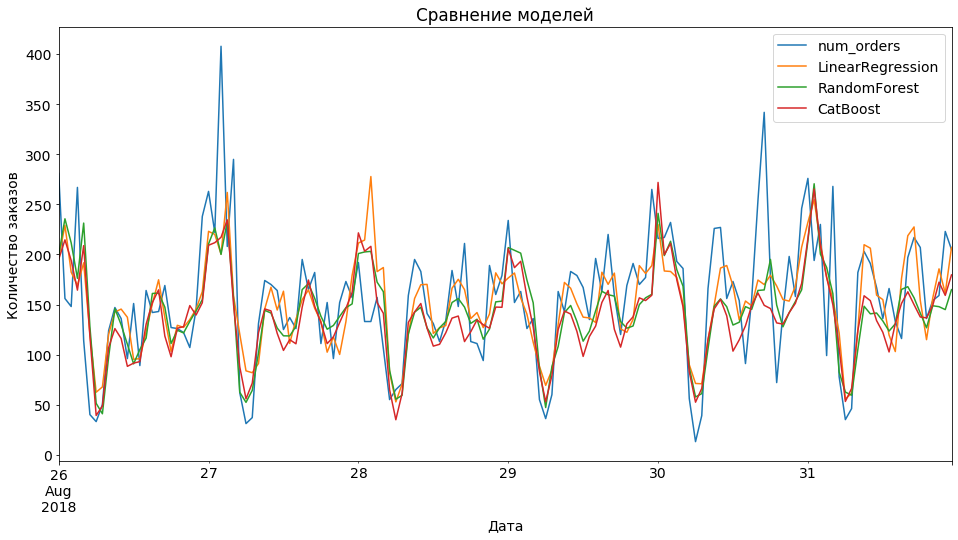

In [26]:
compare_table['2018-08-26':'2018-08-31'].plot(figsize=(16,8))
plt.title('Сравнение моделей')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Все модели неплохо прогнозируют ряд. Конечно, сильные всплески и просадки и случайные выбросы моделям неподвластны, но сравнение с фиктивными предсказаниями показывают, что положительный эффект прогнозирования имеет место быть. 

##  Заключение

- Рассмотрена задача прогнозирования временного ряда.  
- На основании исторических данных, любезно предоставленных компанией «Чётенькое такси», были построеные модели машинного обучения для прогнозирования количества заказов в аэропортах на следующий час.  
- Предоставленные сведения содержат данные с 1 марта по 31 августа 2018 г., что означает, что сезонные колебания учесть невозможно. Однако выявлена циклическая зависимость заказов такси от дня недели и времени суток. 
- Обучено три модели - линейной регрессии, случайного леса и градиентного бустинга (CatBoost). Лучший результат у последней модели, RMSE = 39.65. Самая простая модель - линейной регрессии - показала результат RMSE = 44.7. Все модели показывают качество существенно выше, чем предсказание по скользящему среднему или по предыдущему значению. 